In [1]:
from utils.result import *
%reload_ext autoreload
%autoreload 2

/hpc/home/hy190/AL_generative/result.py:287: RuntimeWarning: divide by zero encountered in divide
  SI_index = (se_raw - se_shuffle)/N1_plus_N2
/hpc/home/hy190/AL_generative/result.py:287: RuntimeWarning: invalid value encountered in divide
  SI_index = (se_raw - se_shuffle)/N1_plus_N2


In [3]:
stimuli = ['P9_TenThous', 'M4', 'Bol', 'Ctl', 'DatExt', 'Far', 'Ger', 'Iso', 
           'Lin', 'M2', 'M3', 'M5', 'P9_Ten', 'M6', 'Mal', 'Myr', 'Ner', 'P3', 
           'P4', 'P5', 'P9', 'P9_Hund', 'Bea']

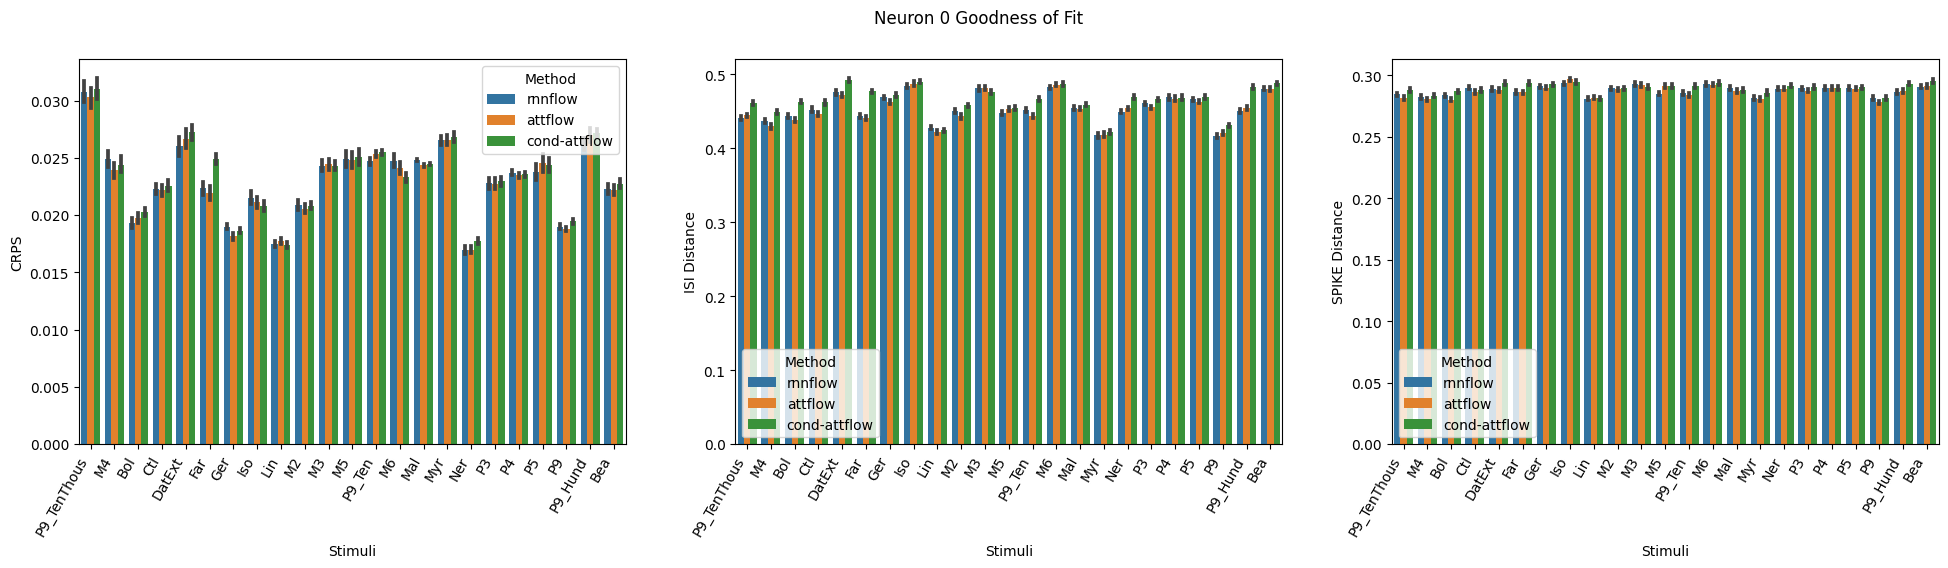

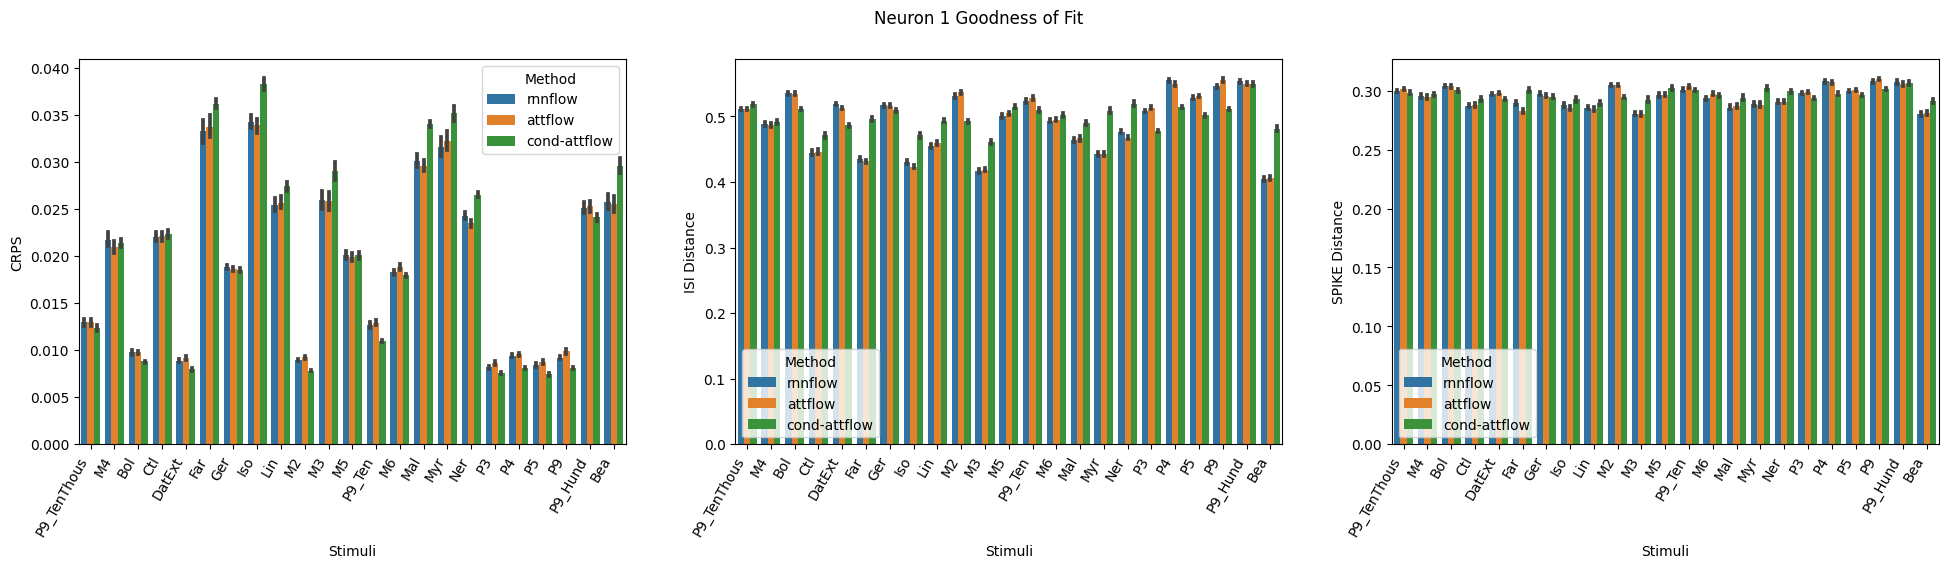

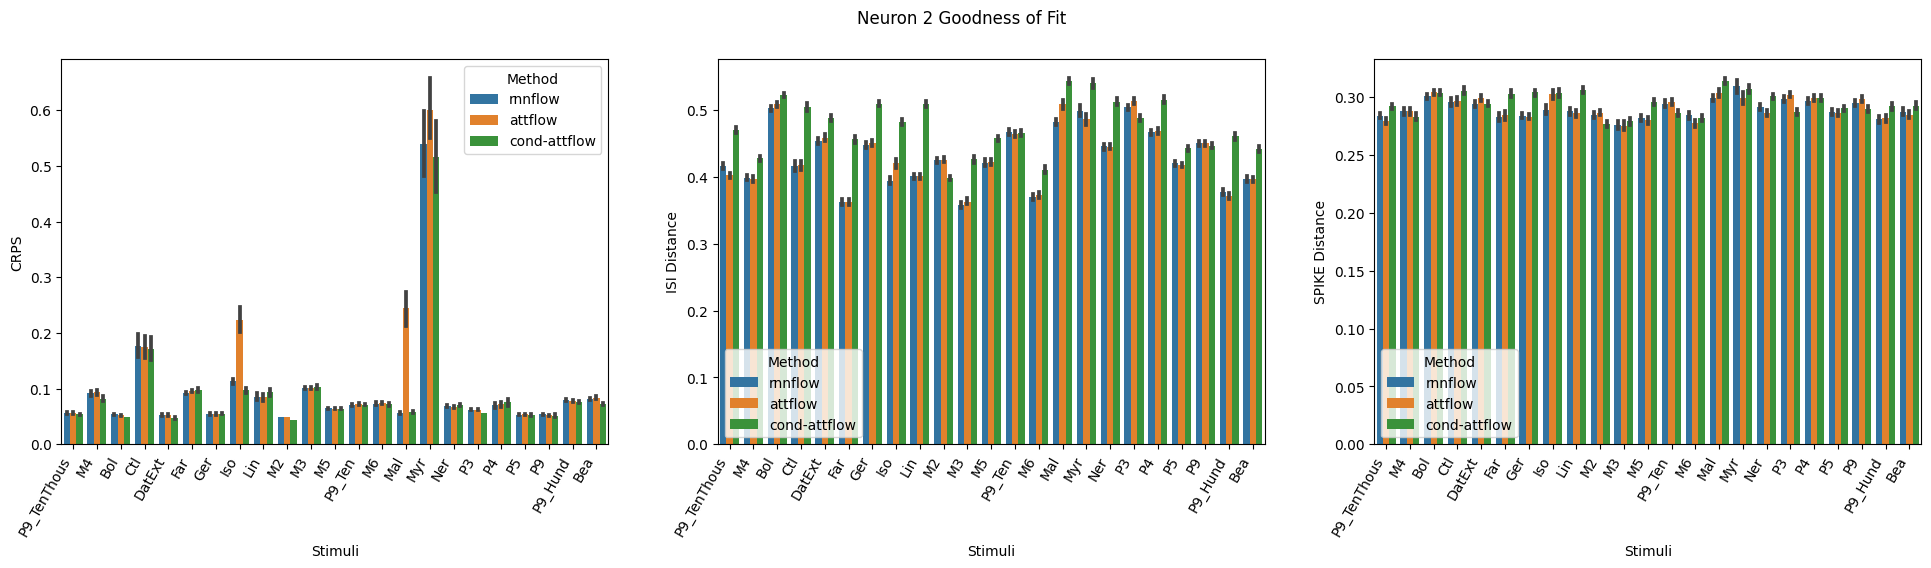

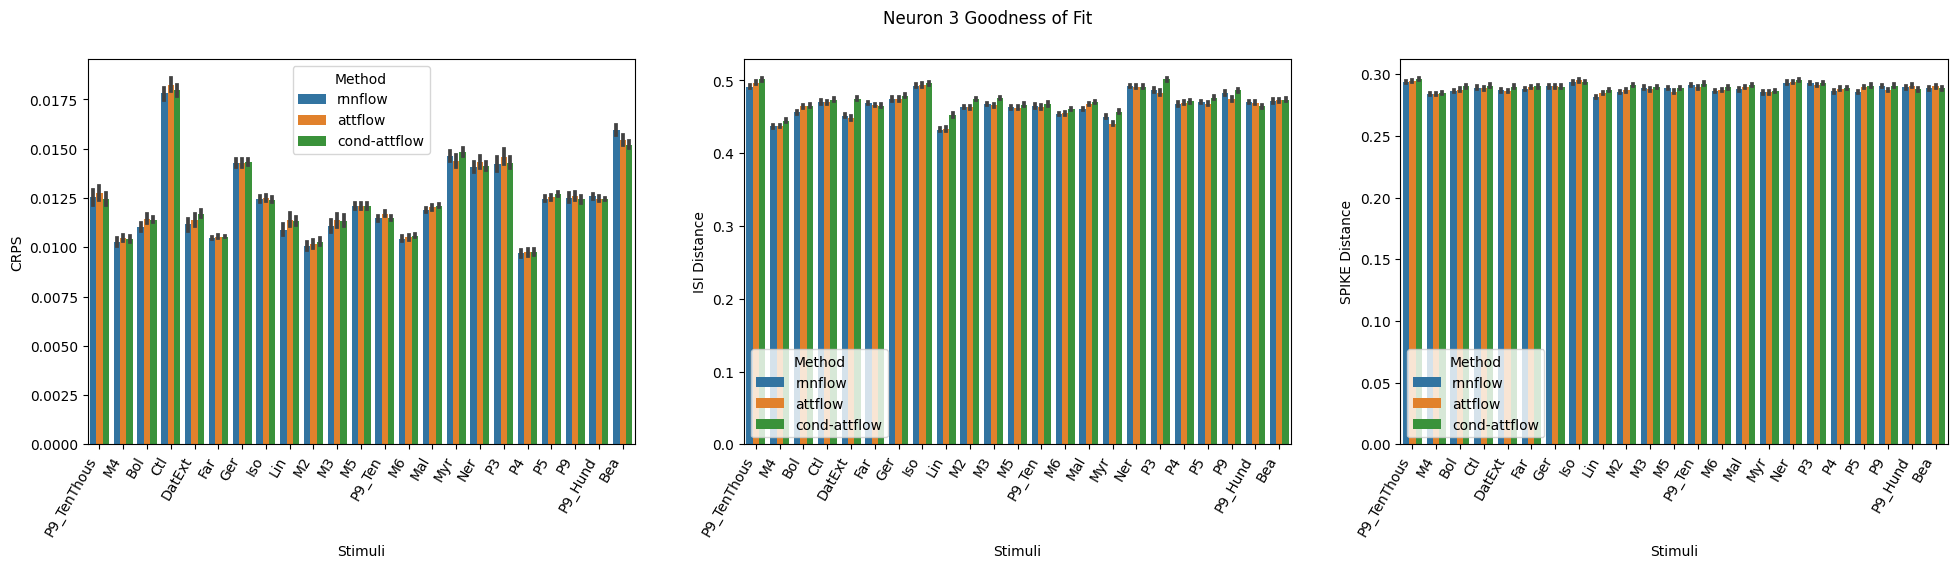

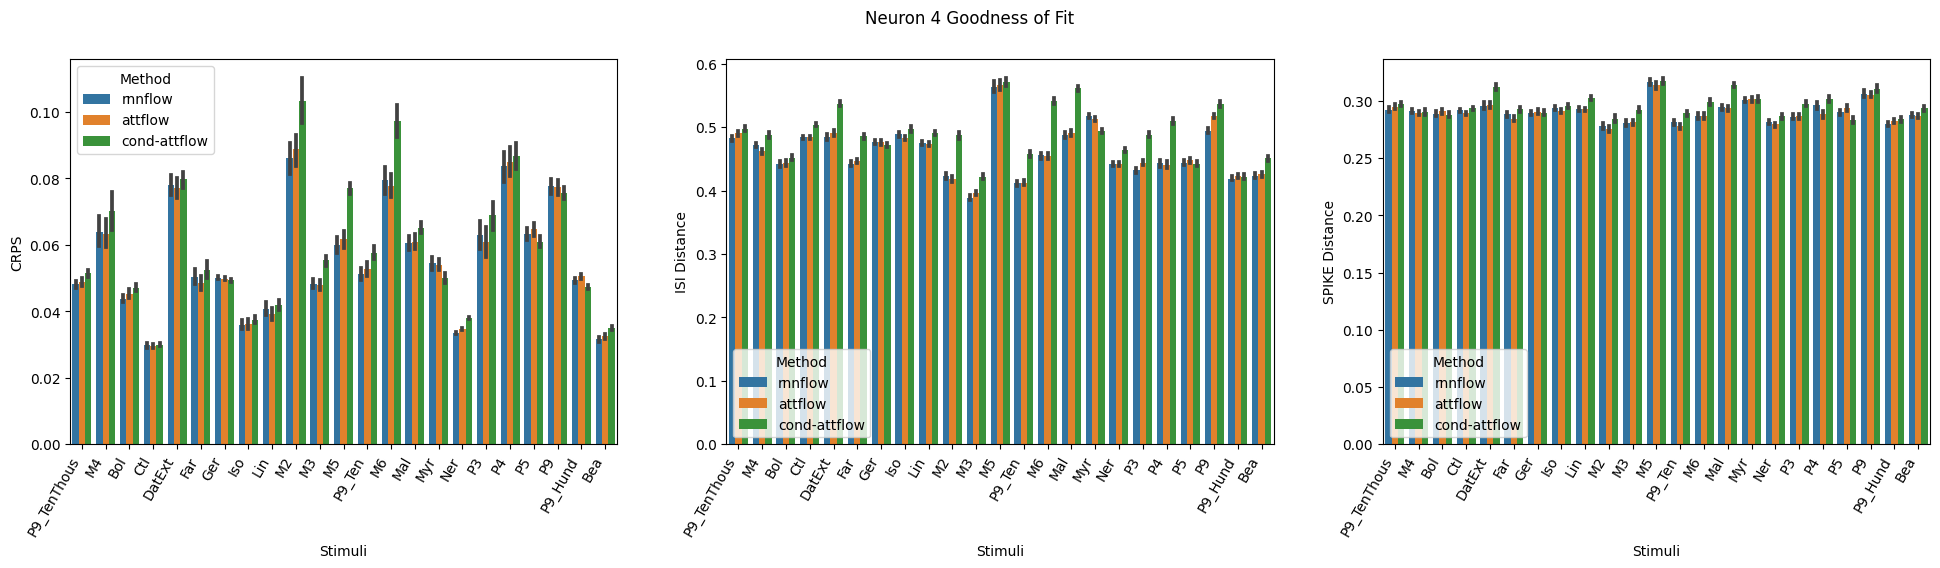

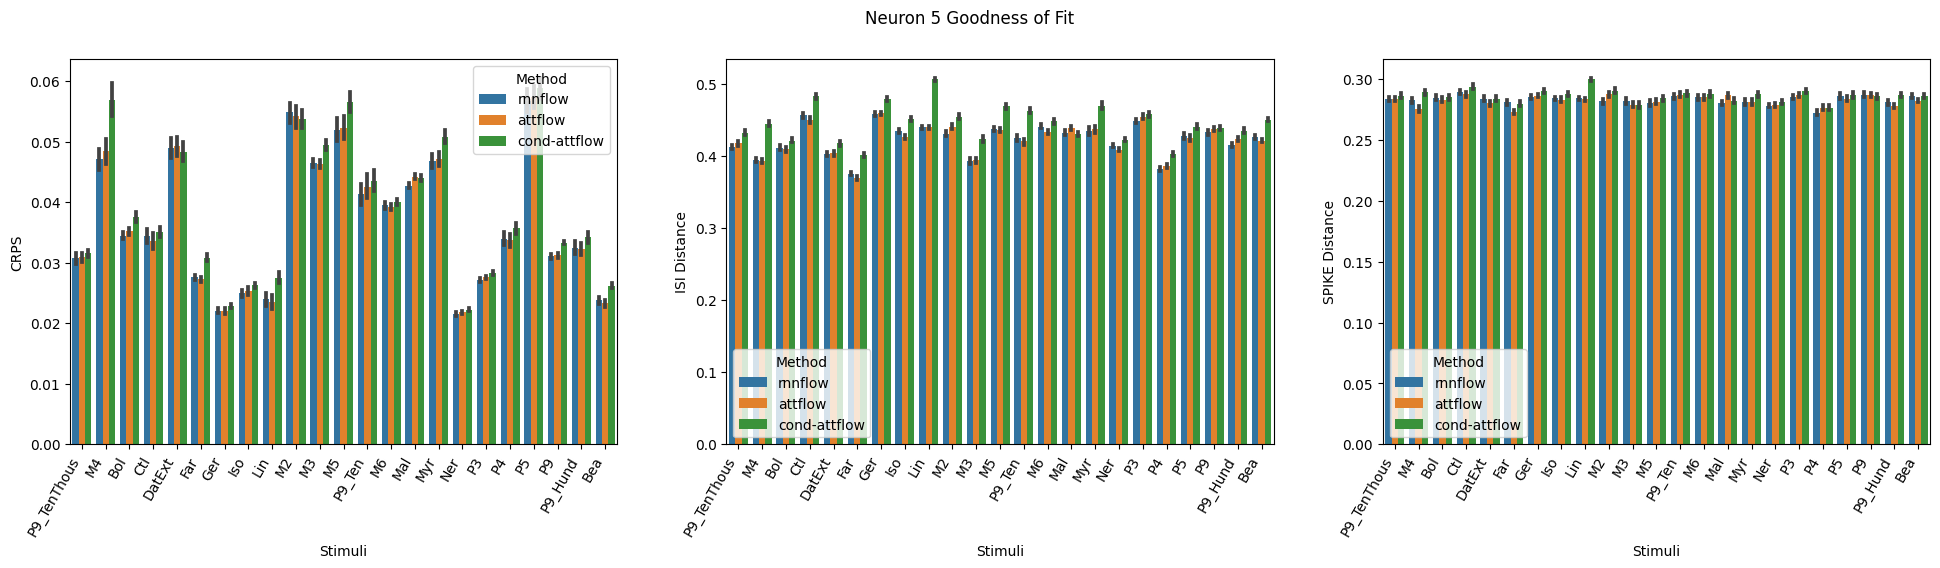

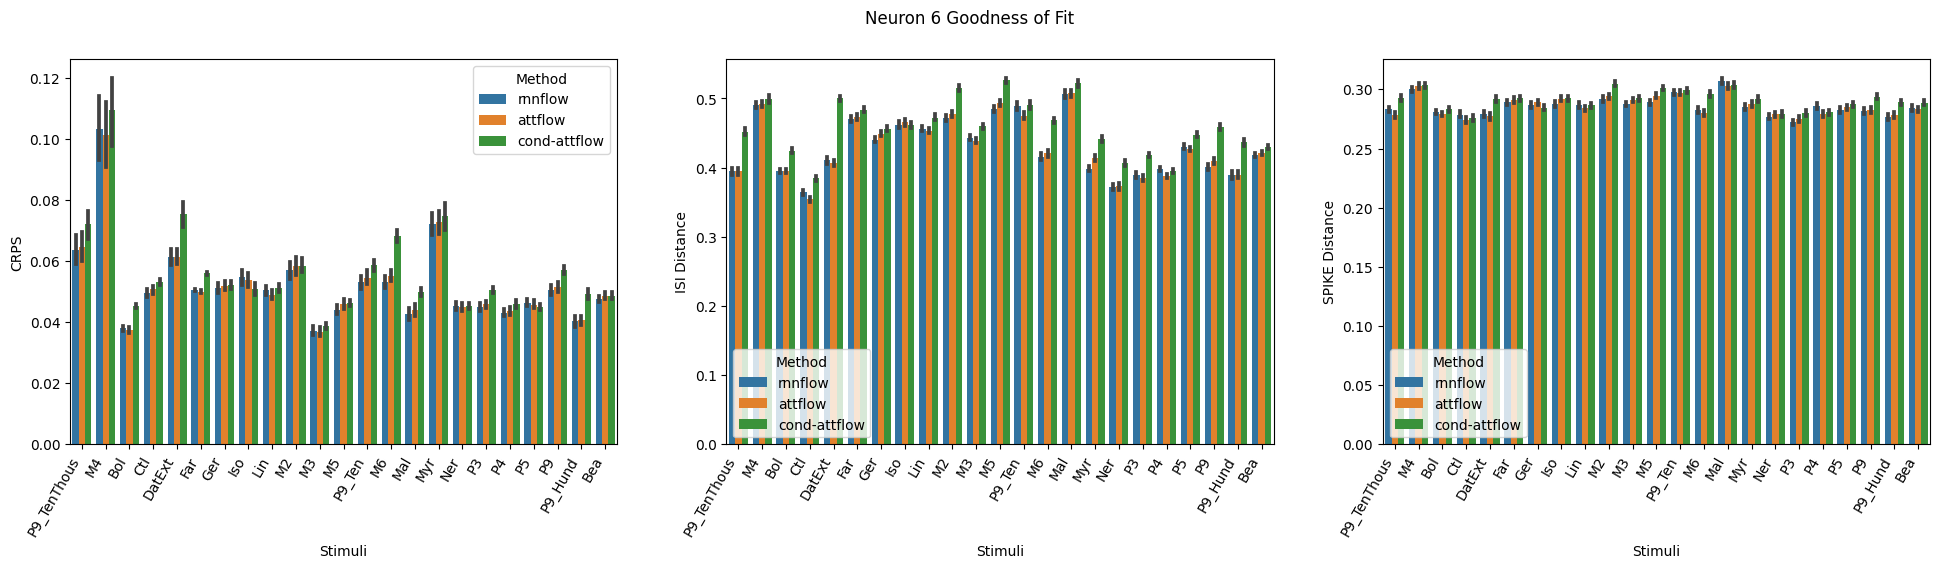

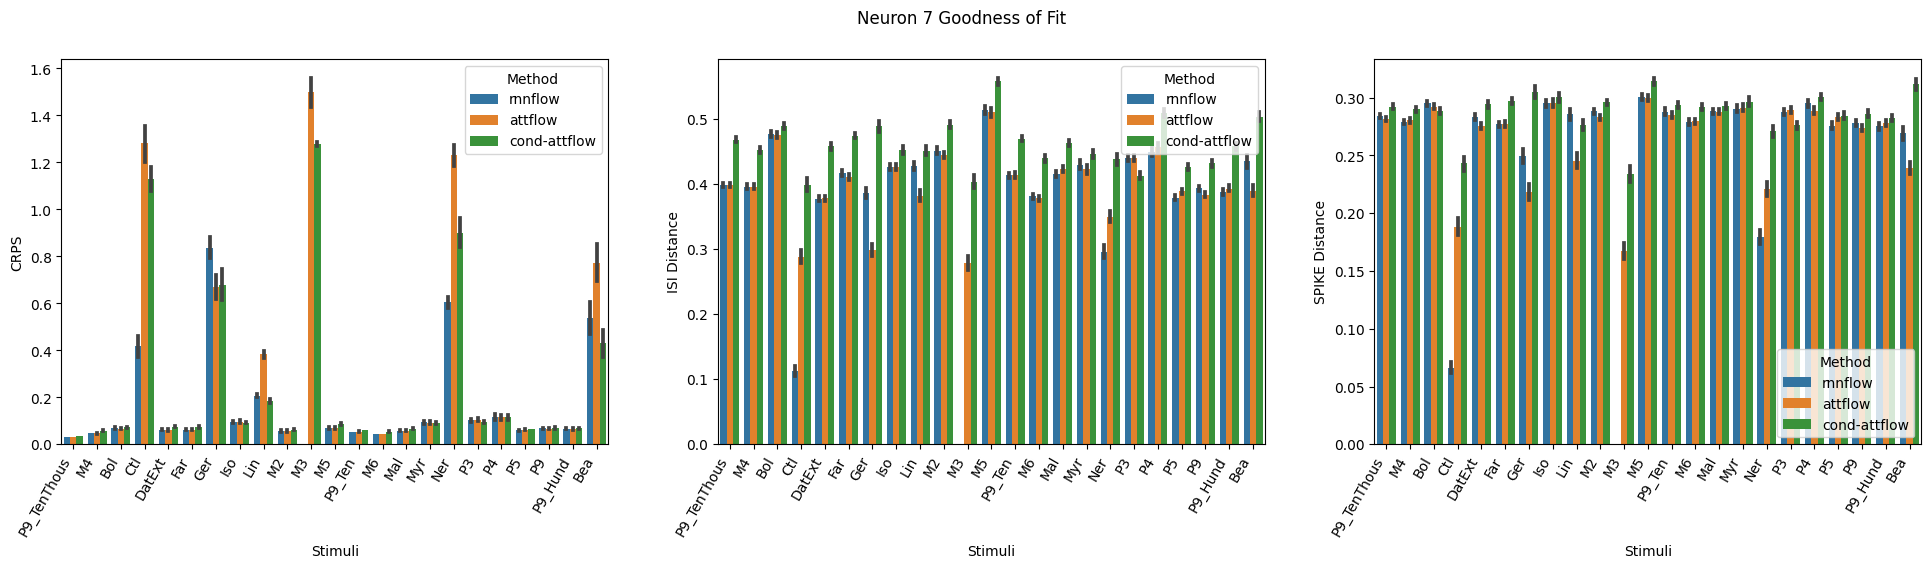

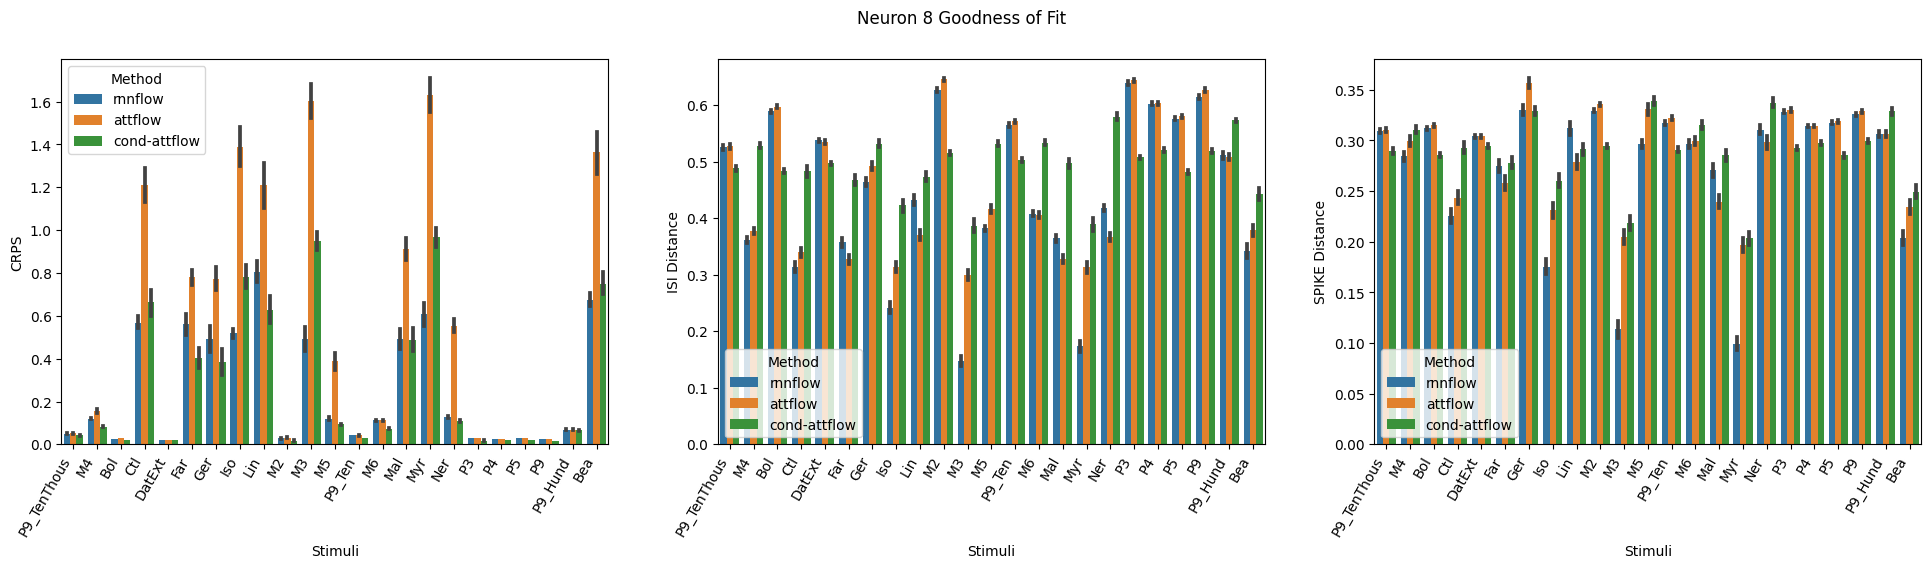

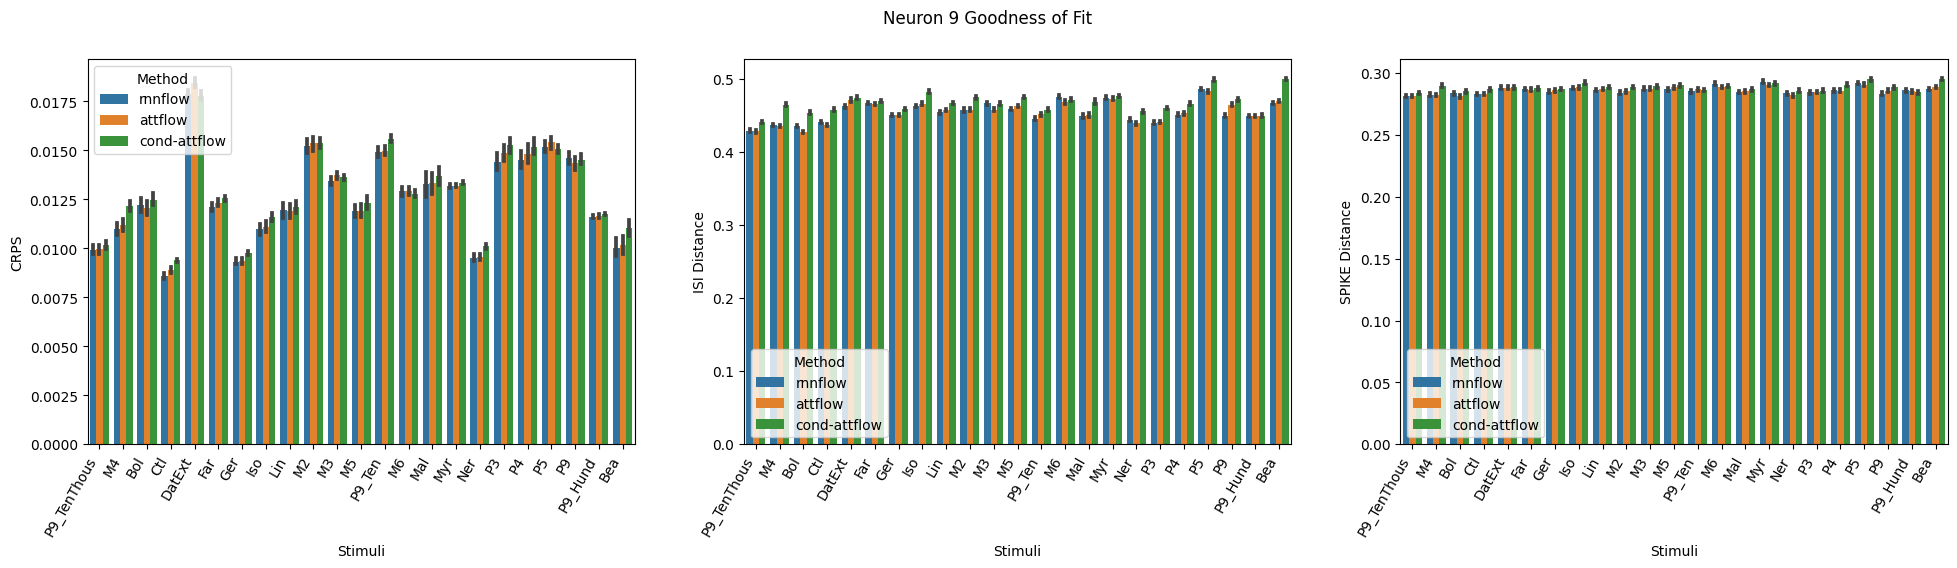

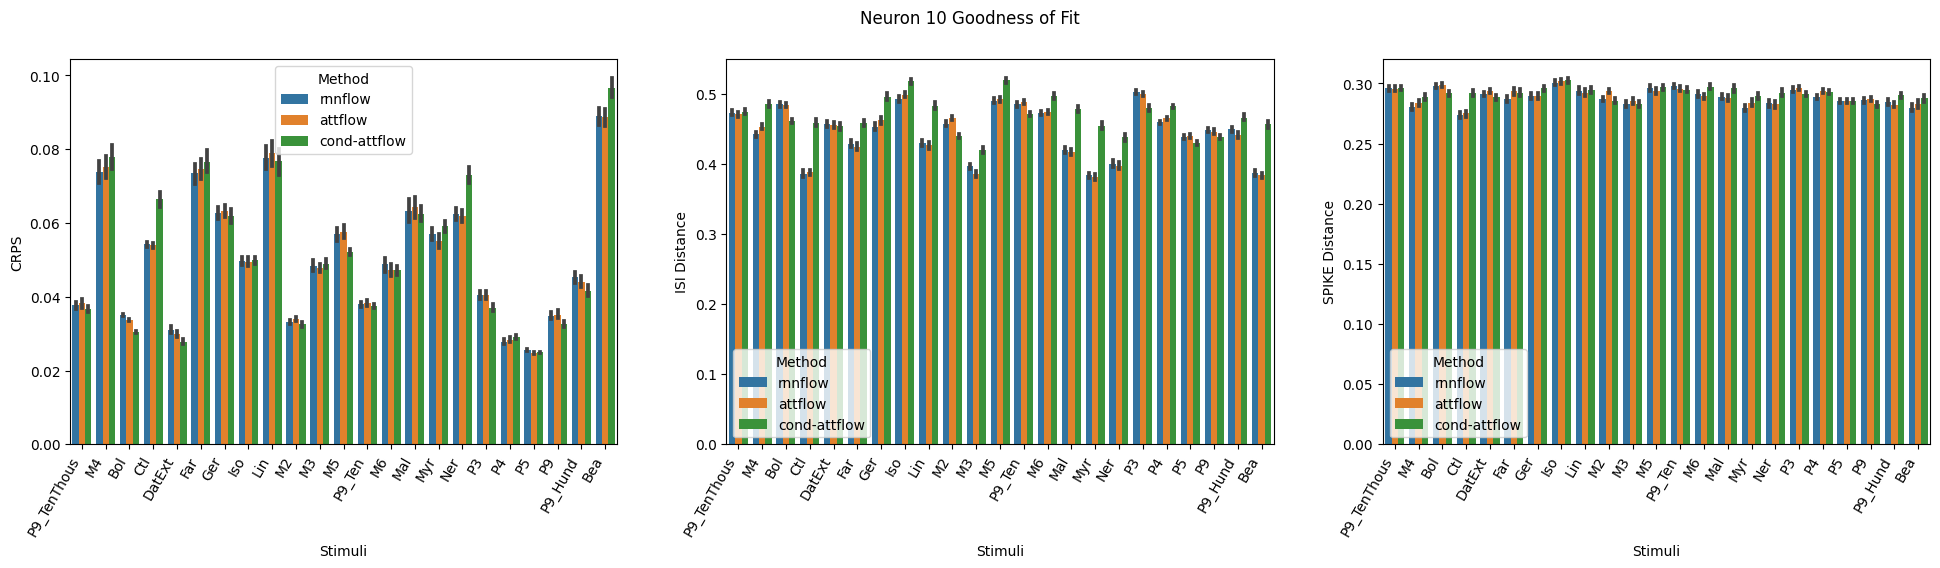

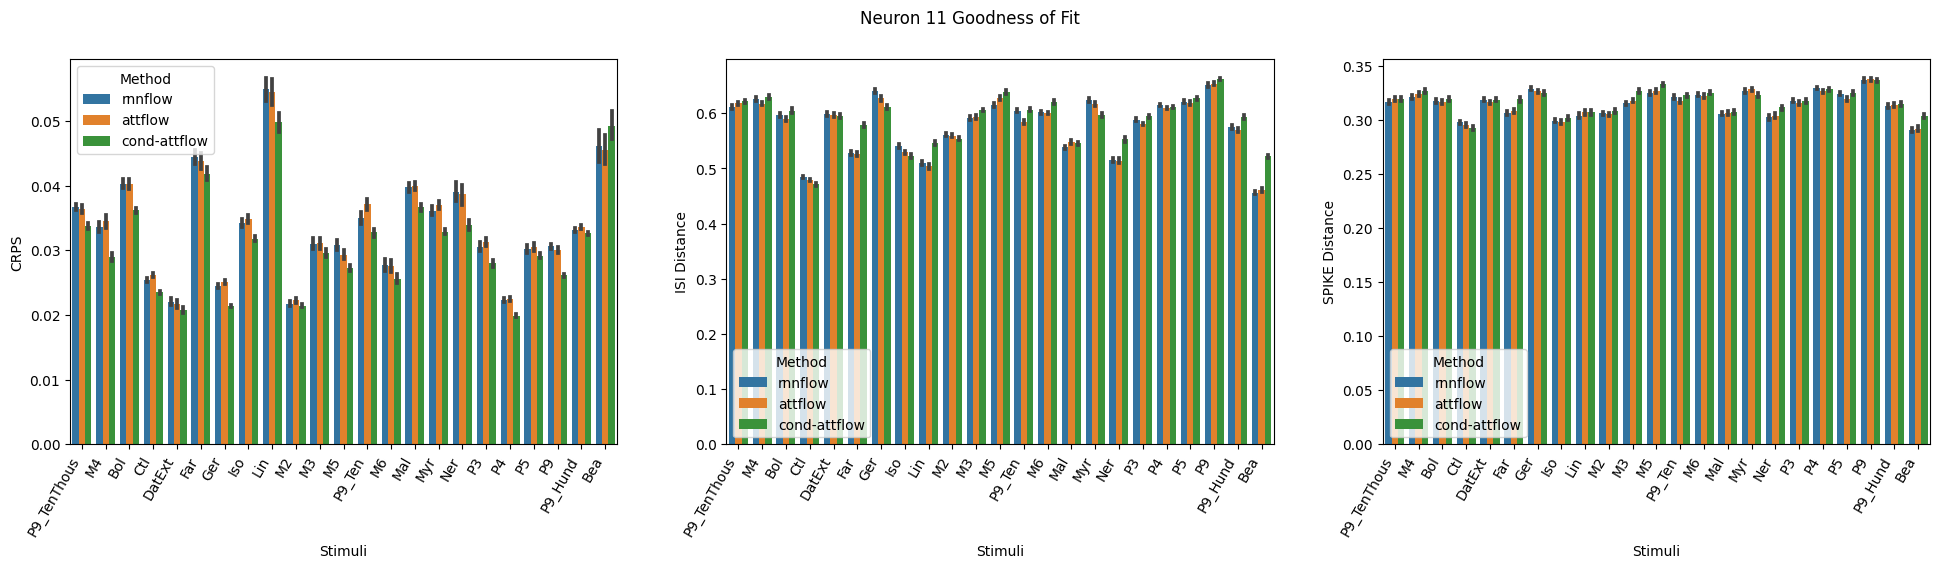

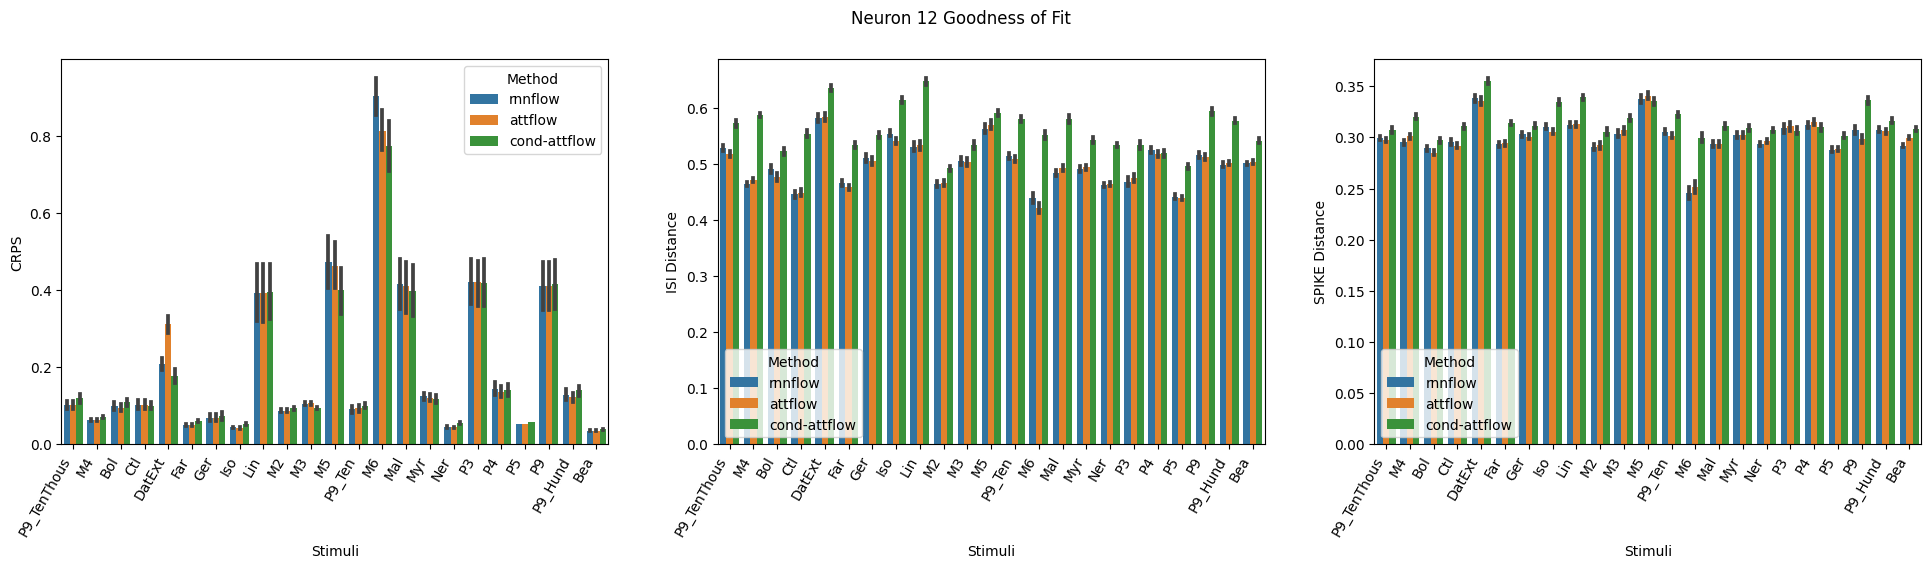

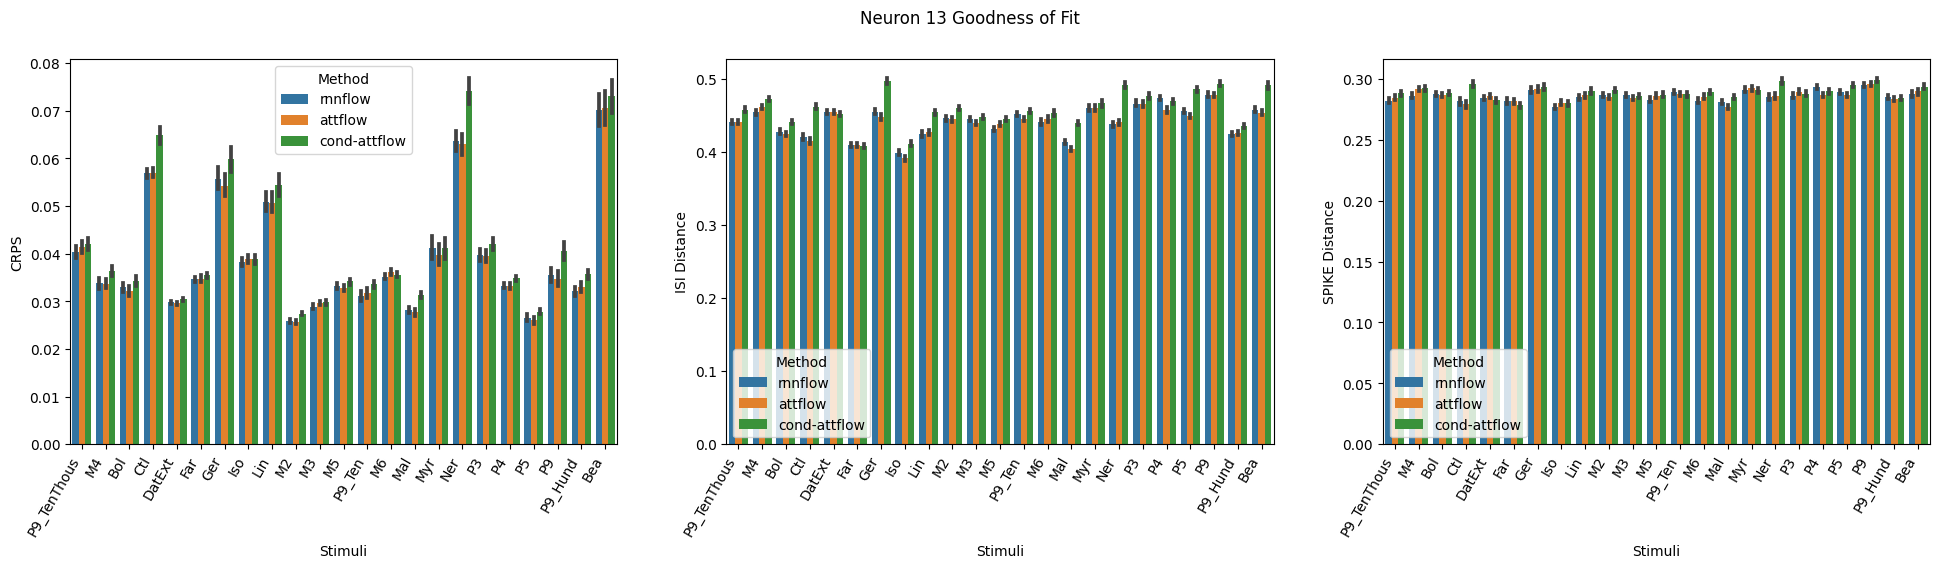

In [9]:
for target in range(0,14):
    rnn_crps_stack, rnn_isi_stack, rnn_spike_stack = analyze_noncond_stim("config/rnnflow/rnnflow-{}.yaml".format(target), 
                                                                         verbose=False)
    att_crps_stack, att_isi_stack, att_spike_stack = analyze_noncond_stim(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), 
                                                                         verbose=False)
    attcond_crps_stack, attcond_isi_stack, attcond_spike_stack = analyze_cond_stim(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), target=target,
                                                                         verbose=False)
    plot_result_bar([rnn_crps_stack, att_crps_stack, attcond_crps_stack],
                [rnn_isi_stack, att_isi_stack, attcond_isi_stack],
                [rnn_spike_stack, att_spike_stack, attcond_spike_stack],
                target, method=["rnnflow", "attflow", "cond-attflow"])

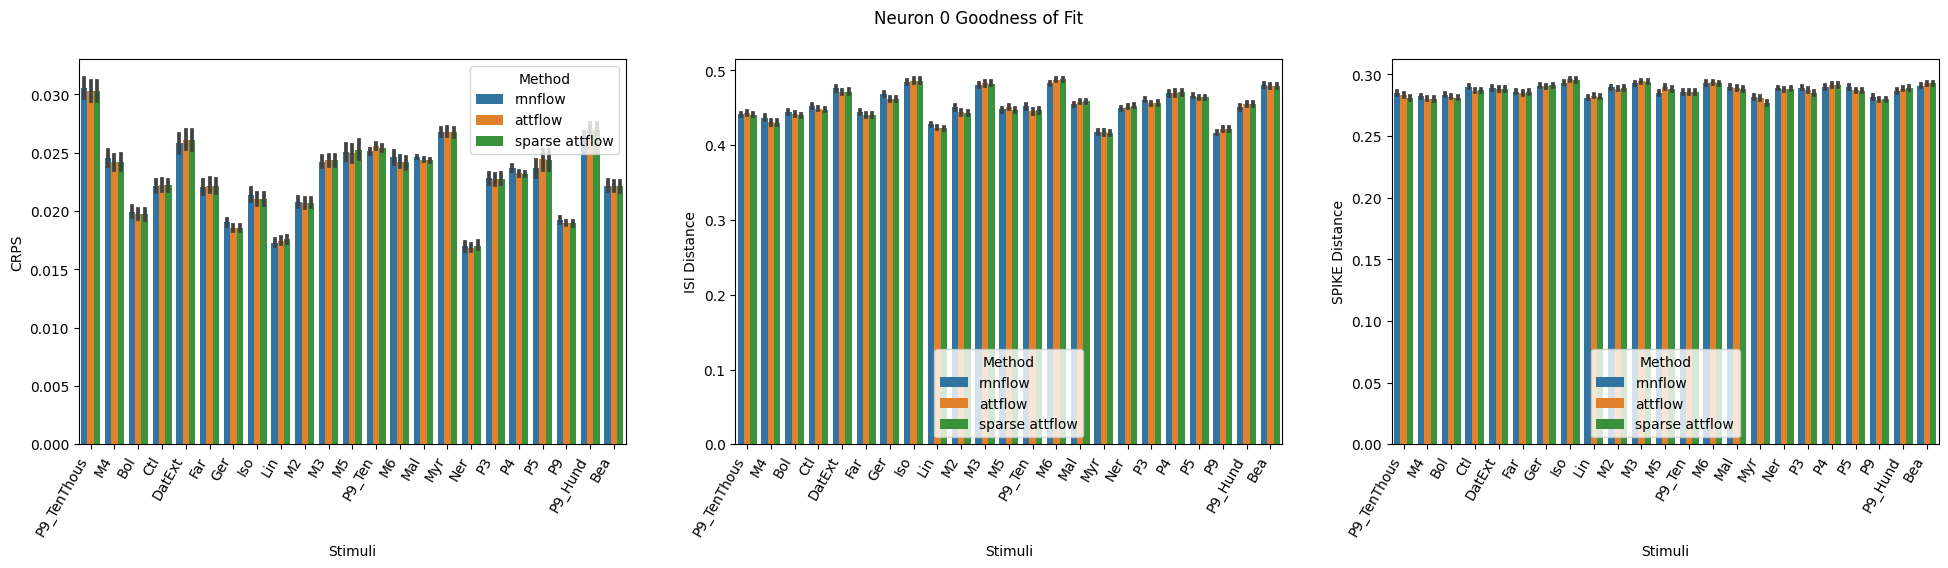

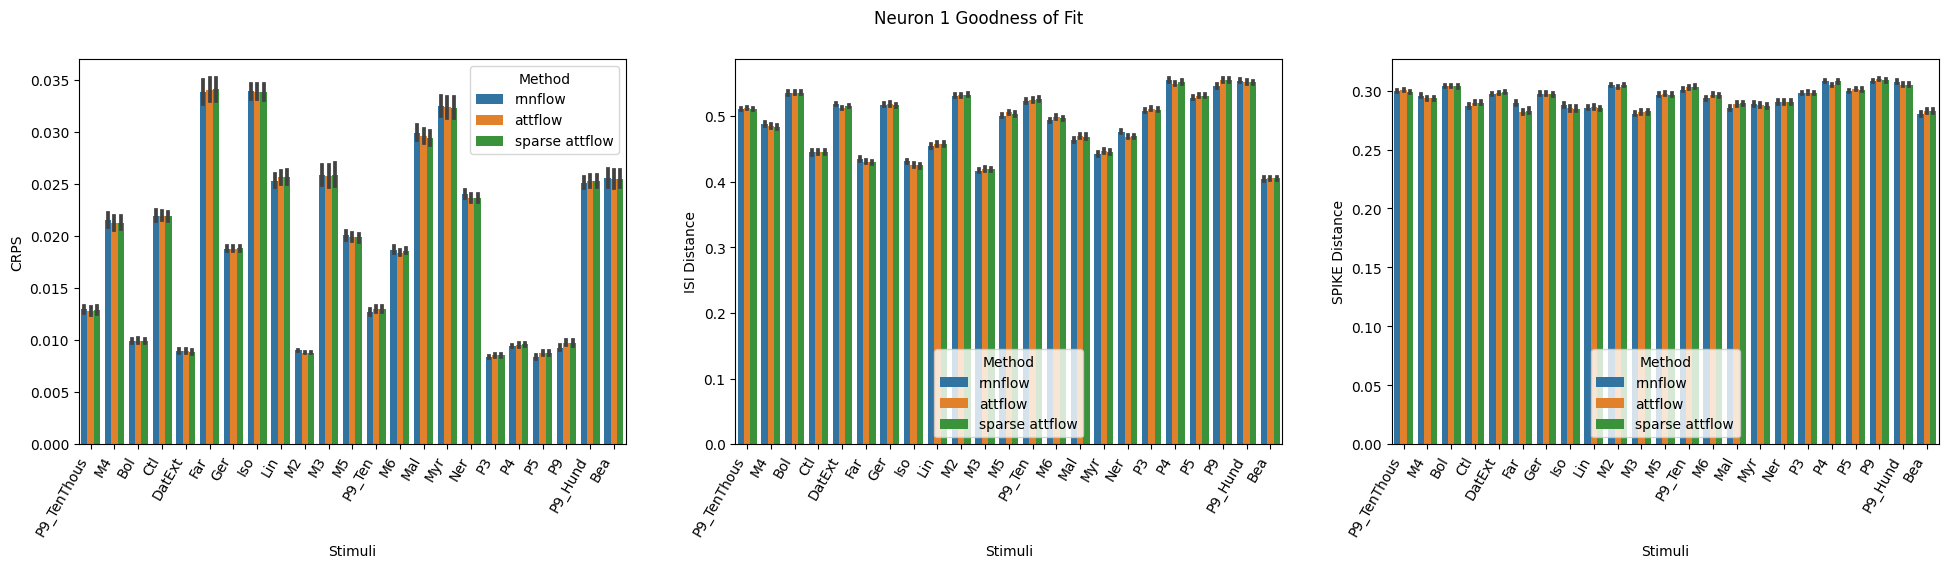

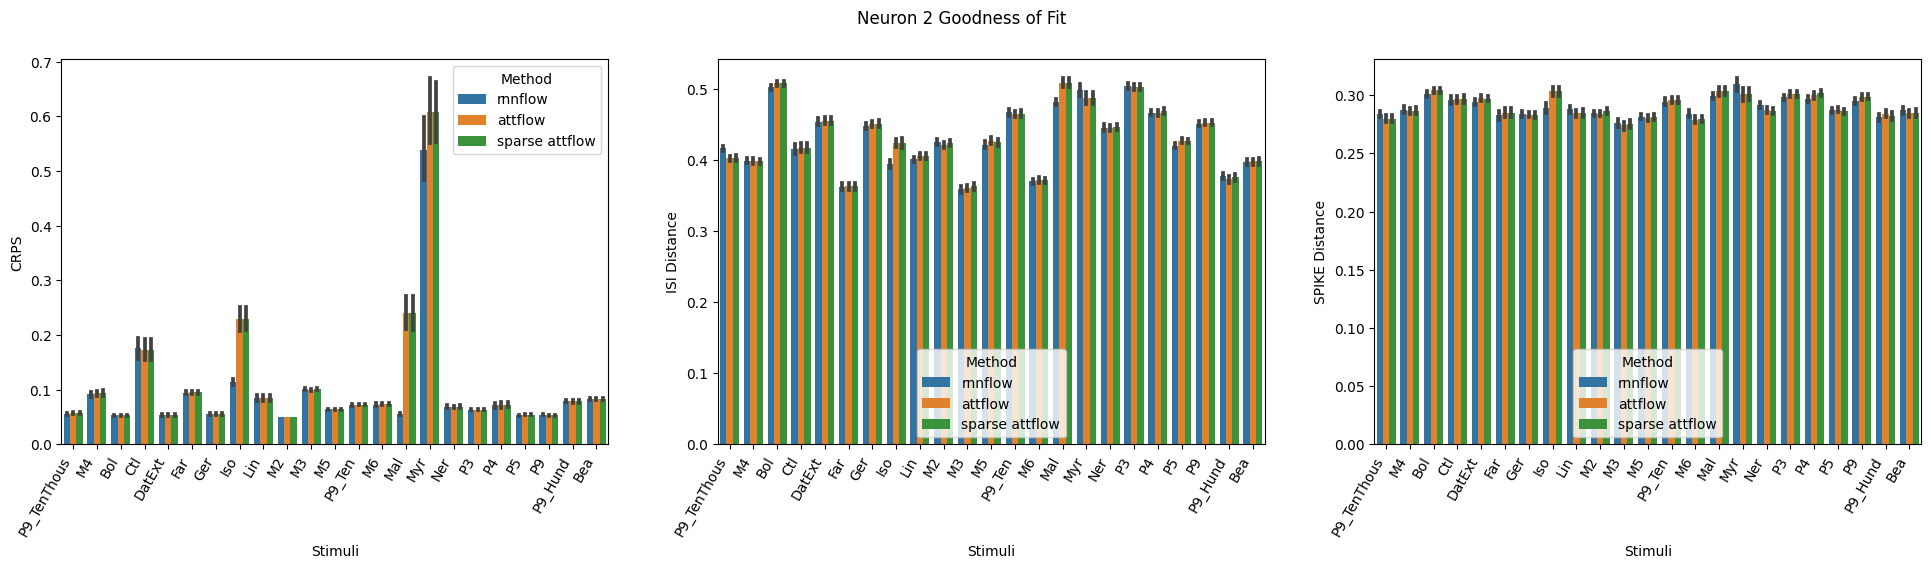

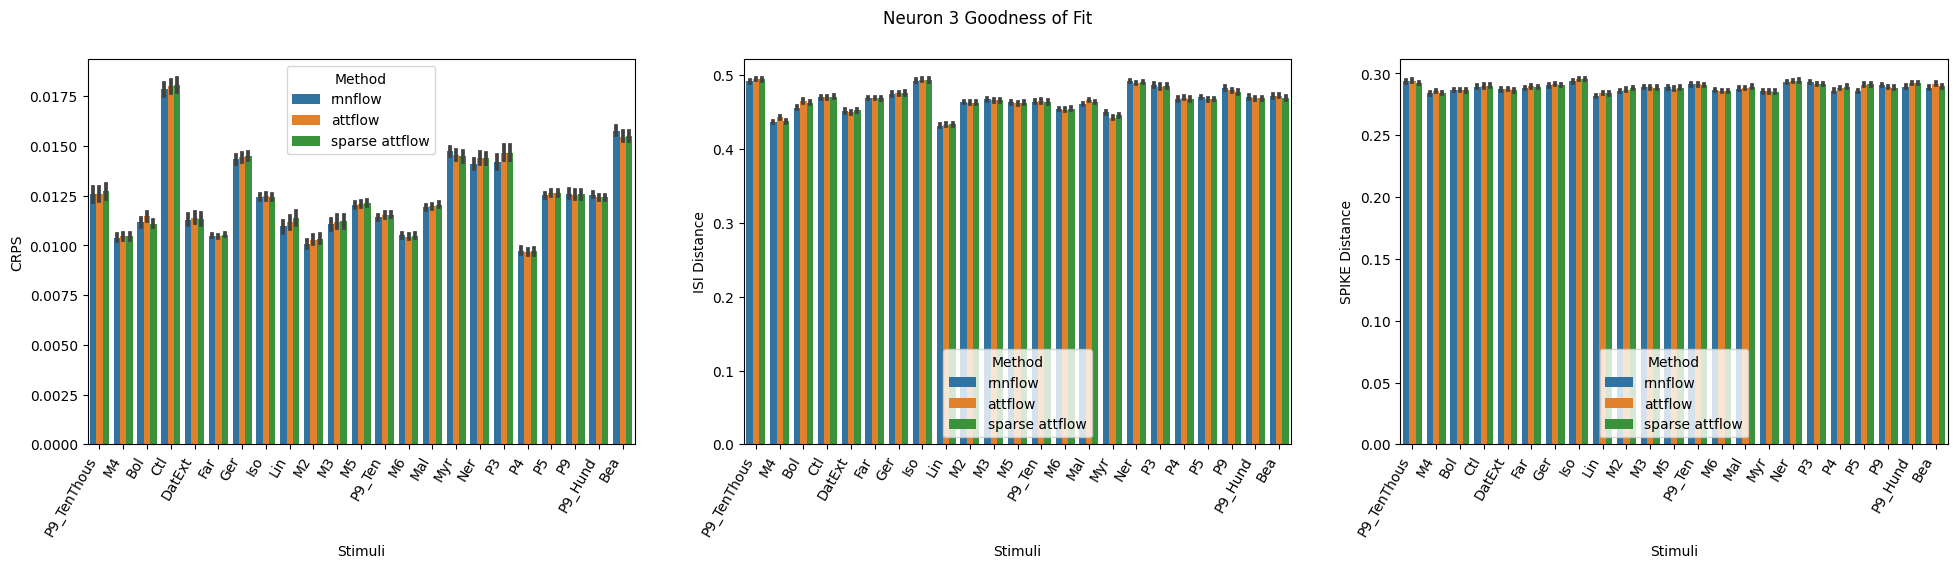

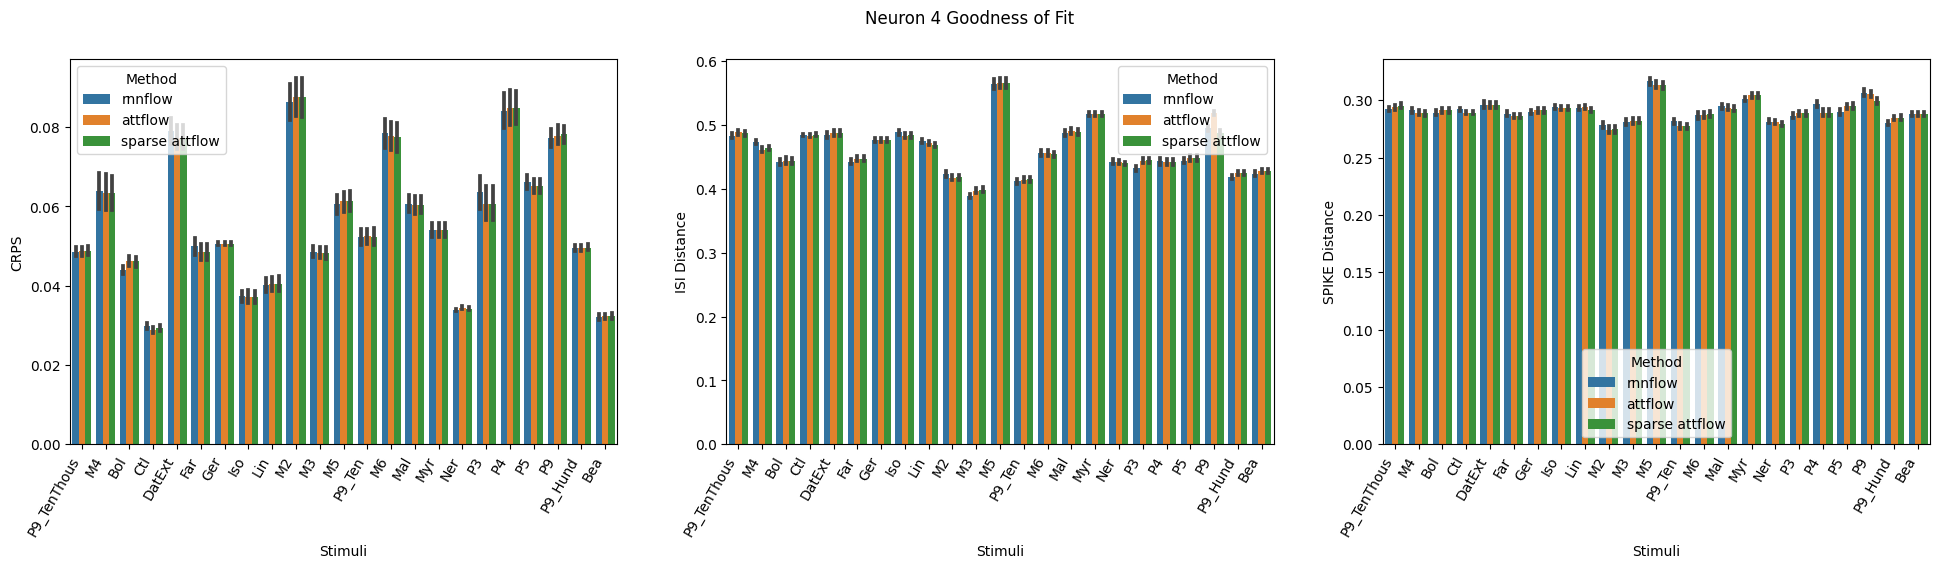

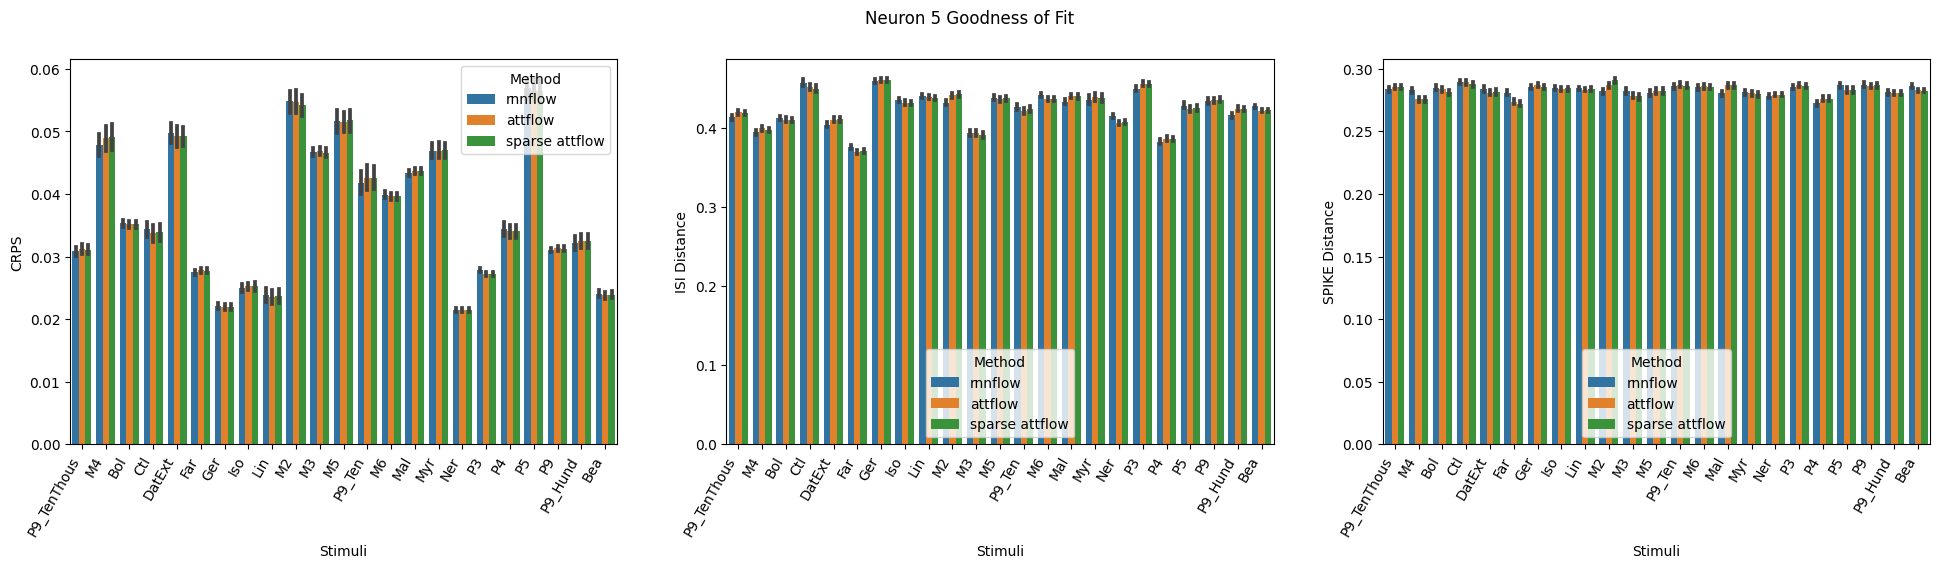

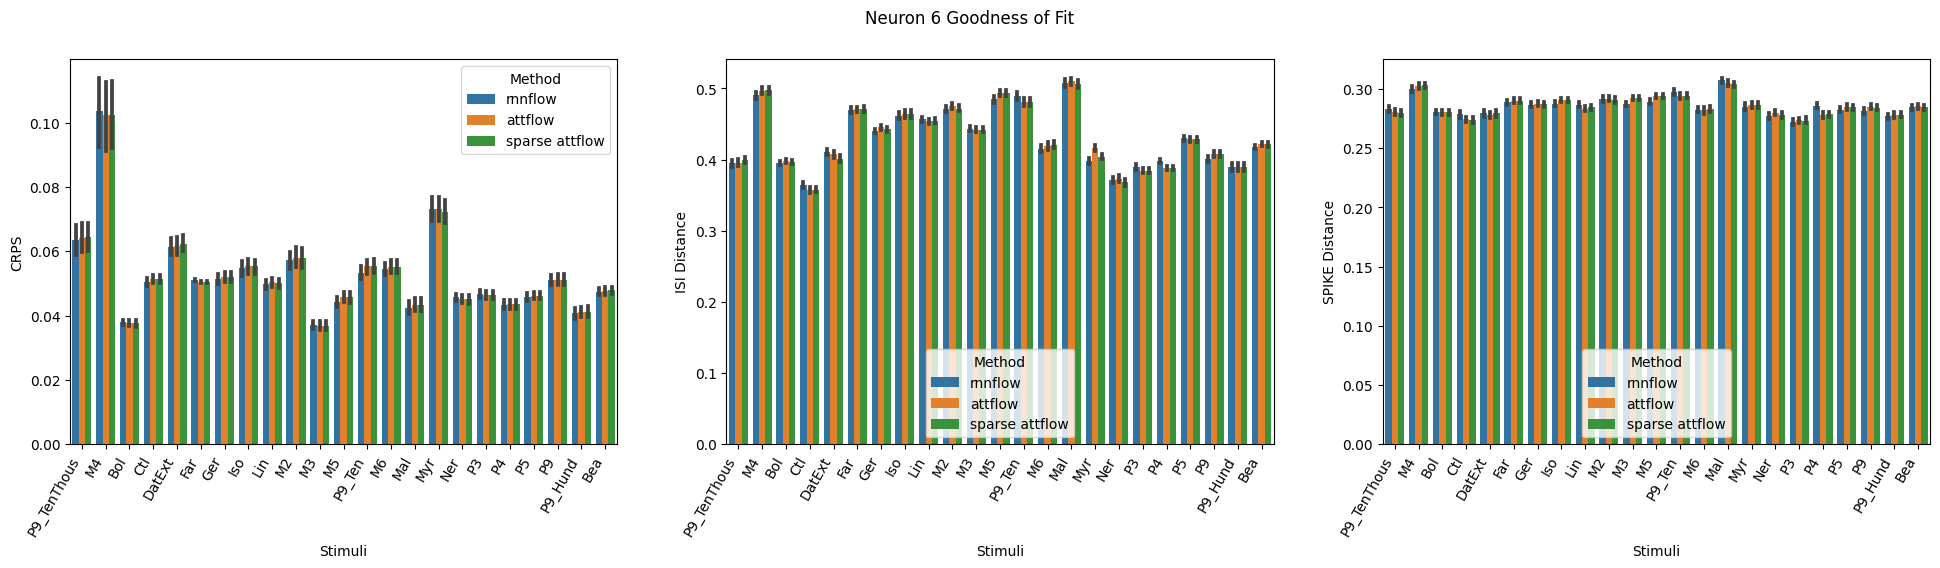

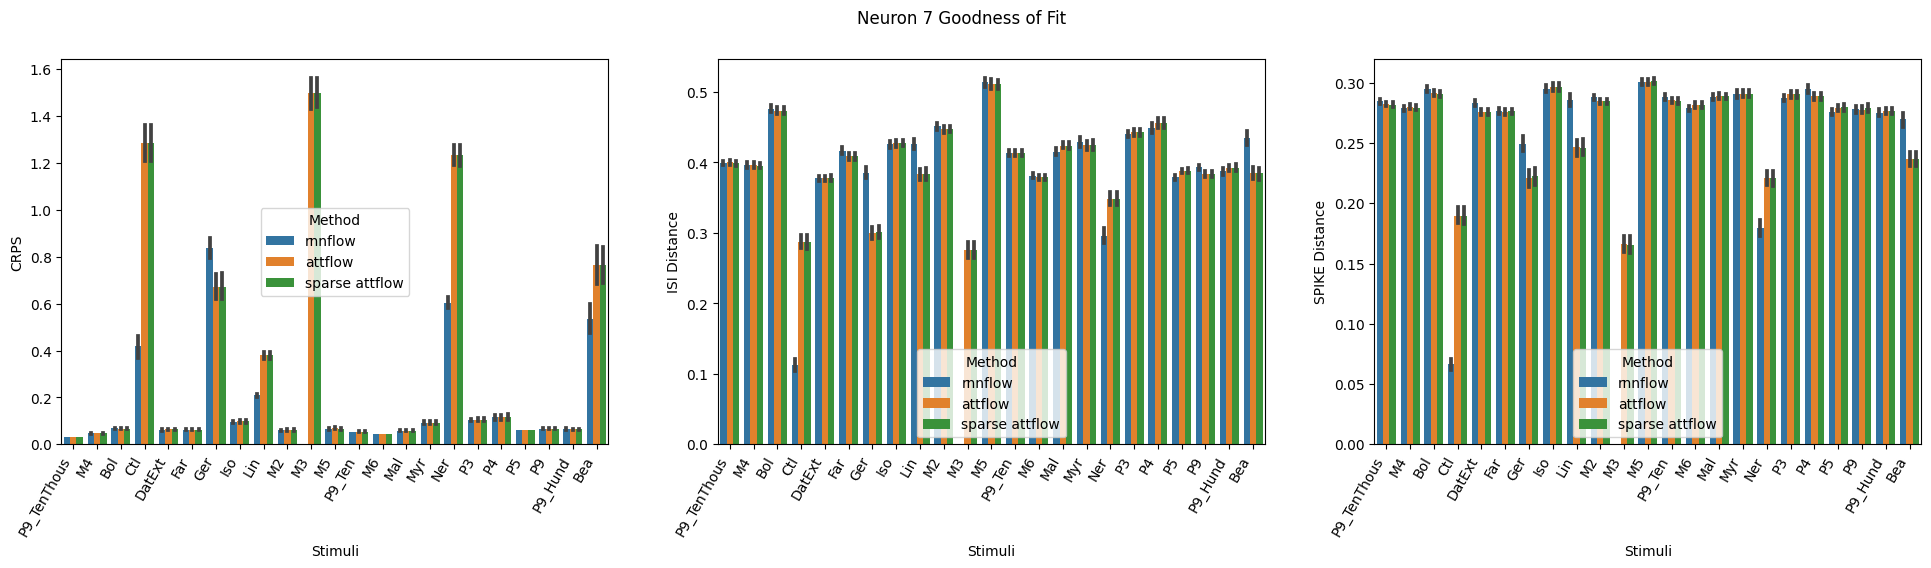

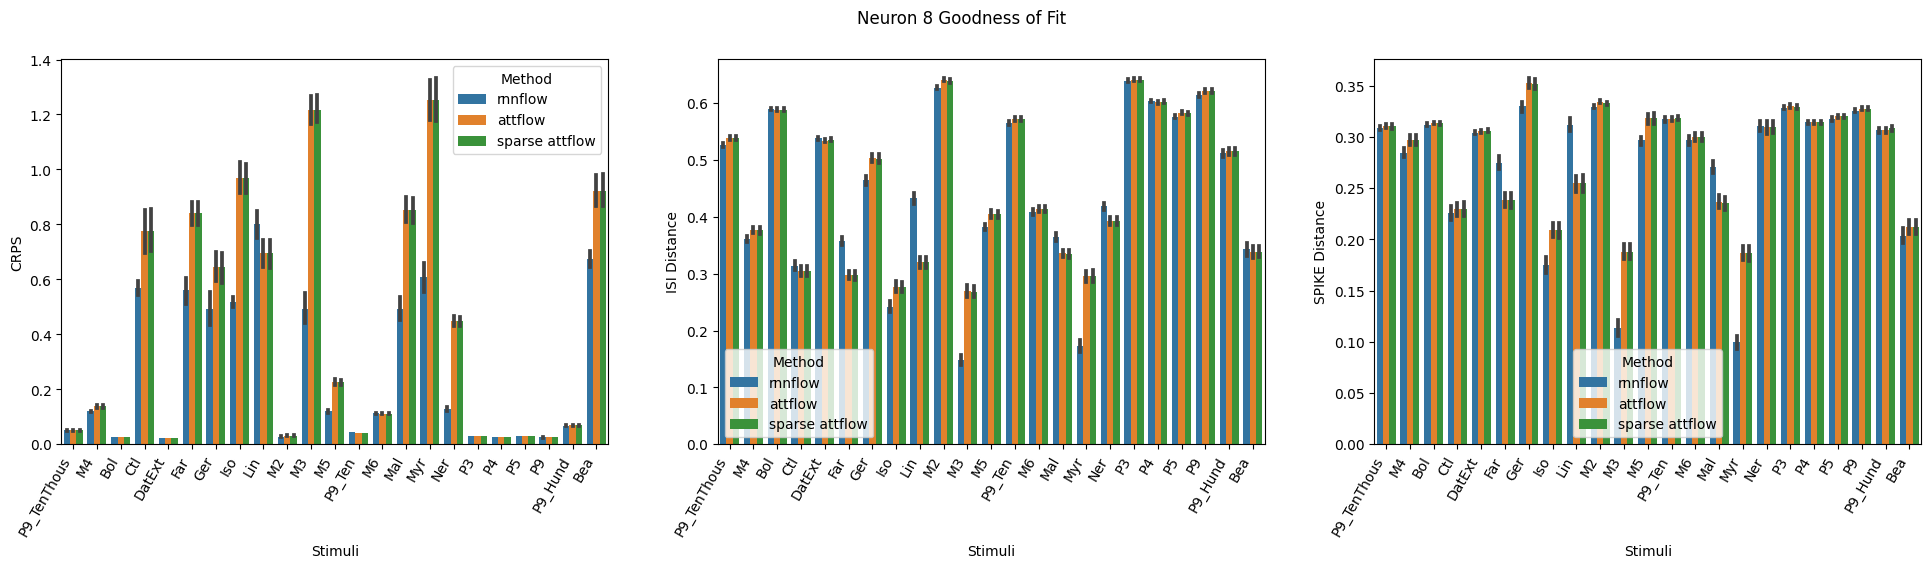

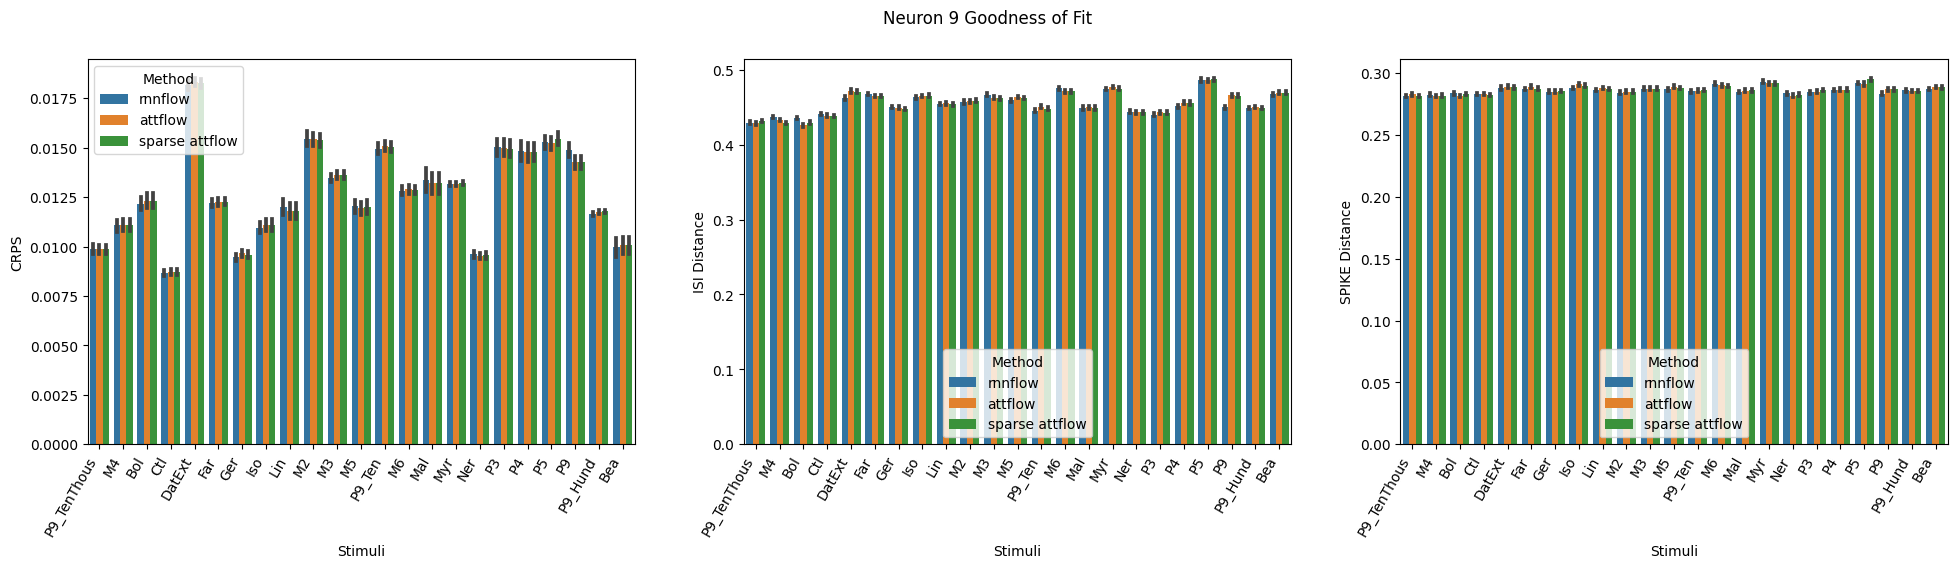

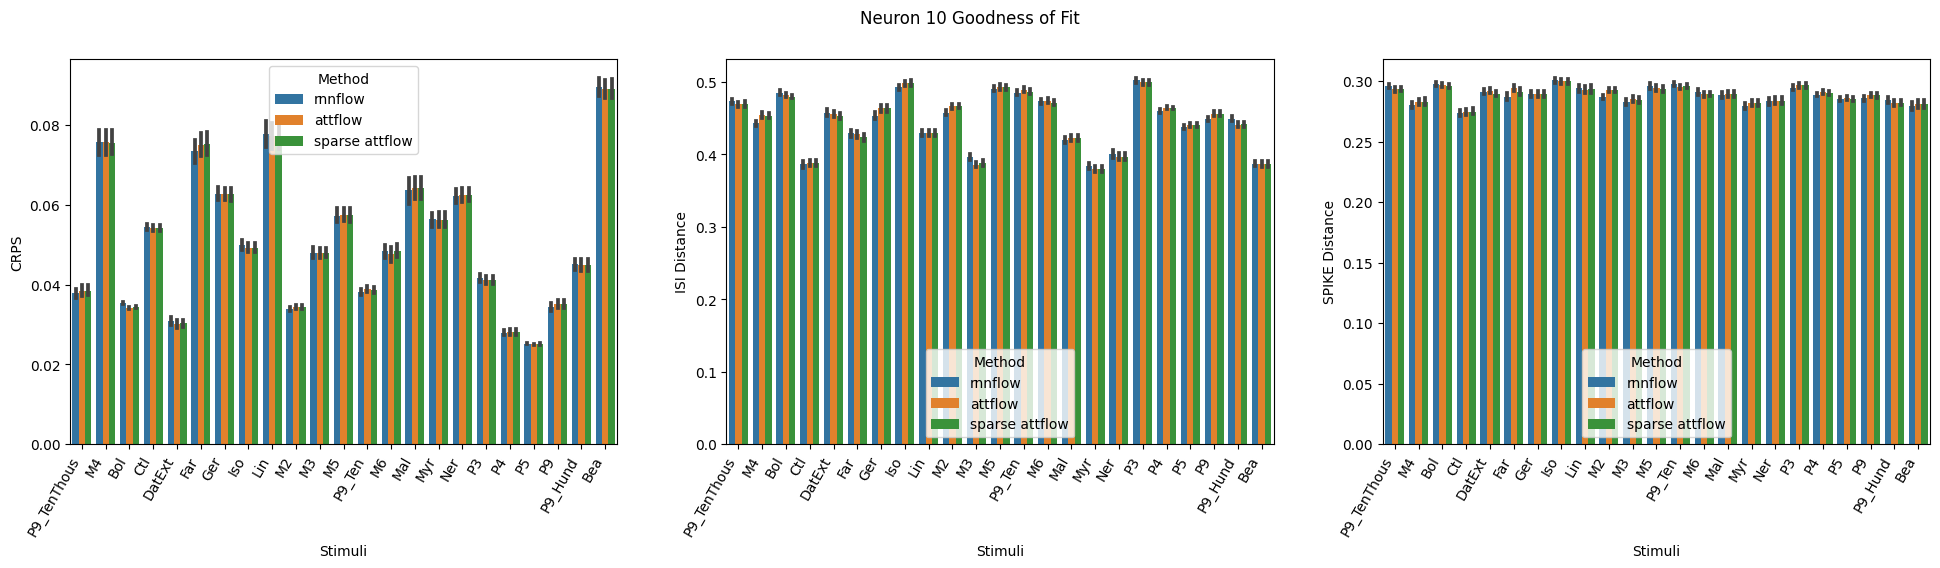

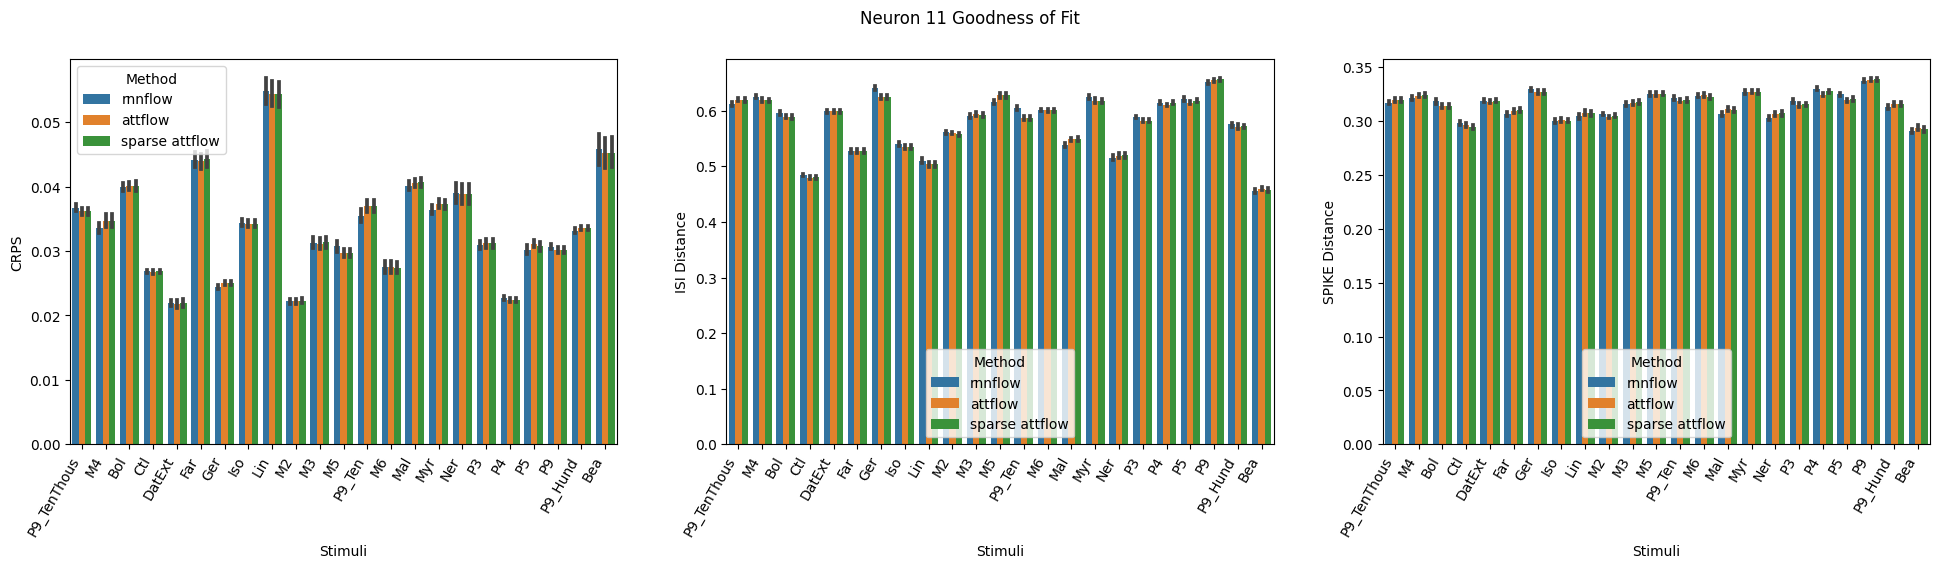

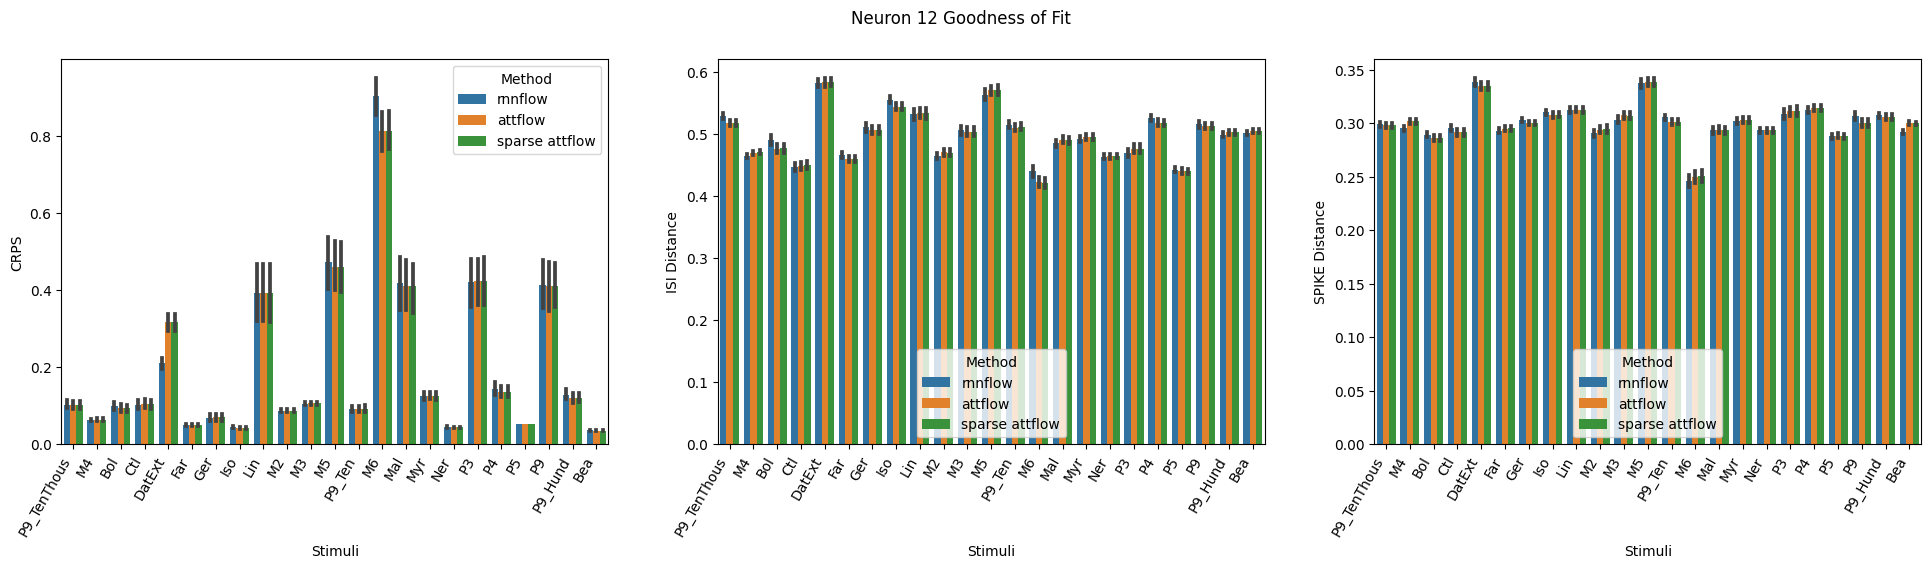

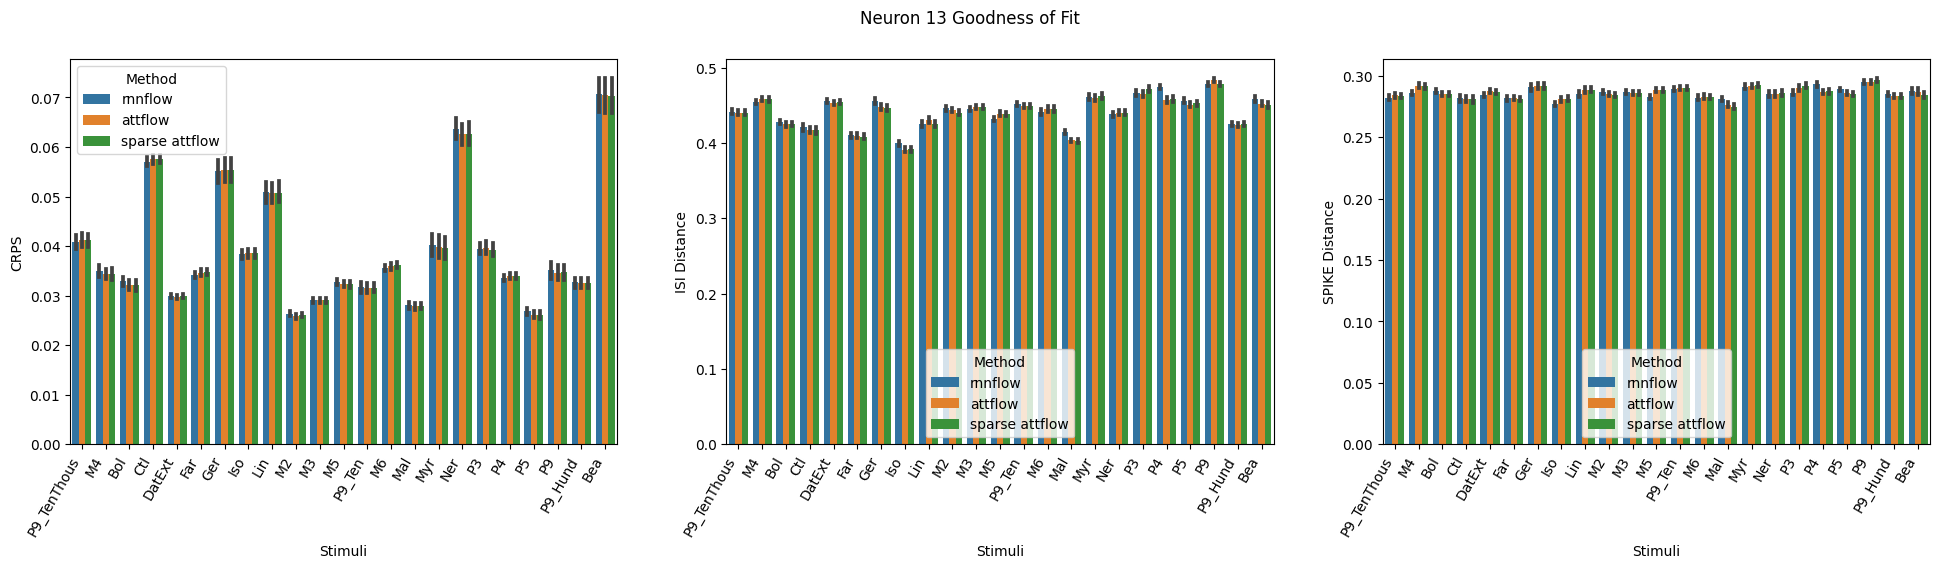

In [5]:
for target in range(0,14):
    rnn_crps_stack, rnn_isi_stack, rnn_spike_stack = analyze_noncond_stim("config/rnnflow/rnnflow-{}.yaml".format(target), 
                                                                         verbose=False)
    att_crps_stack, att_isi_stack, att_spike_stack = analyze_noncond_stim(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), 
                                                                       verbose=False)
    spa_crps_stack, spa_isi_stack, spa_spike_stack = analyze_noncond_stim(yaml_filepath="config/sparse-attflow/sparse-attflow-{}.yaml".format(target), 
                                                                       verbose=False)
    plot_result_bar([rnn_crps_stack, att_crps_stack,spa_crps_stack],
                [rnn_isi_stack, att_isi_stack,spa_isi_stack],
                [rnn_spike_stack, att_spike_stack, spa_spike_stack],
                target, method=["rnnflow", "attflow", "sparse attflow"])

In [10]:
import pandas as pd
path="/hpc/group/tarokhlab/hy190/data/AL/ALdata/070921_cleaned.csv"
df = pd.read_csv(path, index_col=0)


In [16]:
df[["label", "stimuli"]].drop_duplicates()
df["label_stim"] = df["label"].astype(str) + "-" +df["stimuli"]
df["label_stim"].drop_duplicates()

0              0-Bea
5              0-Bol
10             0-Mal
15             0-Myr
20             0-Lin
25             0-Ner
30             0-Ger
35             0-Iso
40             0-Far
45          0-DatExt
50              1-P9
55          1-P9_Ten
60         1-P9_Hund
65     1-P9_TenThous
70             0-Ctl
75              1-P5
80              1-P4
85              1-P3
90              0-M6
95              0-M5
100             0-M4
105             0-M3
110             0-M2
Name: label_stim, dtype: object

In [53]:
neuron_tar

array([0.041, 0.078, 0.098, 0.114, 0.171, 0.188, 0.211, 0.33 , 0.341,
       0.389, 0.428, 0.437, 0.447, 0.456, 0.462, 0.551, 0.559, 0.611,
       0.615, 0.636, 0.682, 0.703, 0.763, 0.822, 0.868, 0.924, 0.966,
       0.988, 0.993, 0.998])

In [ ]:
import pandas as pd
pd.read_csv()